In [41]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import load_workbook
import os
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from config_parameters import DATA_TABLE_FILE, SUMMARY_SIMULATIONS_FILE, STRATEGIES_TABLE_FILE, SIMULATION_DATA_DICT, LOGS_FOLDER


# === 1. Wczytaj dane ===
dane_gieldowe = pd.read_excel(DATA_TABLE_FILE)

start_date = "2021-11-01"  # "2021-11-01"
end_date = "2025-03-01"
start_test_date="2024-02-01"



simulation_data_dir=SIMULATION_DATA_DICT
simulation_data_specific = os.path.join(simulation_data_dir, f"{start_date}_to_{end_date}")
#2023-08-01
all_training_preprocessed_path = "all_training_preprocessed.feather"



intervals=['1w', '3d','2d', '1d', '12h', '6h', '4h', '2h', '1h', '30m', '15m']
intervals=[ '12h', '6h', '4h', '2h', '1h']
intervals=[ '4h', '2h', '1h','30m', '15m']
intervals=['6h', '4h', '2h', '1h', '30m', '15m']
type="L"
strategy="1.4"
min_profit=1
commission=0.002

scaler_distance=MinMaxScaler()

category_choose="CRYPTO"
# Lista do przechowania danych


 # for strategies porównuje wyniki modelu
def add_range_features(df, target_df, col_name, ranges, prefix):
    """
    Dodaje do target_df kolumny binarne na podstawie przedziałów wartości z df[col_name].

    Parametry:
    - df: DataFrame źródłowy (np. train_df)
    - target_df: DataFrame, do którego mają być dodane nowe kolumny (np. X_train)
    - col_name: nazwa kolumny w df, której dotyczą przedziały
    - ranges: lista tupli (dolna_granica, górna_granica) lub 'lt'/'gt' dla wartości skrajnych
    - prefix: prefix nazw nowych kolumn
    """
    series = df[col_name]

    for r in ranges:
        if isinstance(r, str):  # np. 'lt_30' lub 'gt_80'
            if 'lt_' in r:
                val = float(r.replace('lt_', ''))
                col = f'{prefix}_lt_{int(val)}'
                condition = series < val
            elif 'gt_' in r:
                val = float(r.replace('gt_', ''))
                col = f'{prefix}_gt_{int(val)}'
                condition = series > val
            else:
                raise ValueError(f'Nieznany zakres: {r}')
        else:
            low, high = r
            col = f'{prefix}_{int(low)}_{int(high)}'
            condition = (series >= low) & (series < high)
        
        target_df[col] = condition.astype(int)

def add_normalized_ema_distance_feature(df, target_df, ema_periods, is_test=False, prefix='norm_ema_dist', close_col='close at entry', atr_col='ATR at entry'):
    """
    Dodaje znormalizowaną cechę: odległość między 'close' a EMA, przeskalowaną przez ATR i znormalizowaną.
    
    Parametry:
    - df: DataFrame źródłowy (np. train_df)
    - target_df: DataFrame, do którego dodajemy kolumnę wynikową (np. X_train)
    - ema_periods: lista int, np. [20, 50, 100]
    - close_col: kolumna ceny
    - atr_col: kolumna z ATR
    - prefix: nazwa kolumny wynikowej
    """
    total_dist = np.zeros(df.shape[0])  # zamiast len(df) – gwarantuje działanie

    for period in ema_periods:
        ema_col = f'EMA_{period} at entry'
        if ema_col in df.columns:
            distance = np.log1p(np.abs(df[close_col] - df[ema_col]) / df[atr_col])
            total_dist += np.sqrt(distance)
        else:
            print(f"⚠️ Kolumna {ema_col} nie istnieje w danych!")

    # Upewnij się, że total_dist to ndarray
    total_dist = np.array(total_dist).reshape(-1, 1)

    # Normalizacja
    if is_test:
        normalized = scaler_distance.transform(total_dist).flatten()
    else:
        normalized = scaler_distance.fit_transform(total_dist).flatten()

    target_df[prefix] = normalized



def create_X(train_df, is_test=False):

    X_train = pd.DataFrame()
# Wybór istniejących kolumn
# X['MACD'] = df['MACD at entry']

    # add_normalized_ema_distance_feature(
    #     df=train_df,
    #     target_df=X_train,
    #     ema_periods=[20, 50, 100],
    #     is_test=is_test,
    #     prefix="norm_short_ema_distance"
    # )

    # #add_normalized_ema_distance_feature(
    #     df=train_df,
    #     target_df=X_train,
    #     ema_periods=[200, 500, 595]  , 
    #     is_test=is_test,
    #     prefix="norm_long_ema_distance"

    # )

    add_range_features(train_df, X_train, 'RSI at entry', ['lt_30', (30, 40), (40, 50), (50, 65), (65, 75)], 'RSI')


    add_range_features(
        train_df,
        X_train,
        'Williams_%R at entry',
        ['lt_-80', (-80, -60), (-60, -40), (-40, -20)],
        'William'
    )

    add_range_features(
        train_df,
        X_train,
        'K at entry',
        ['lt_20', (20, 50), (50, 70), (70, 90)],
        'K'
    )
    add_range_features(
        train_df,
        X_train,
        'D at entry',
        ['lt_20', (20, 50), (50, 70), (70, 90)],
        'D'
    )



    #X['RSI_gt_75']      = (df['RSI at entry'] > 75).astype(int)
    X_train['SMA20>SMA100']=(train_df['SMA_20 at entry'] > train_df['SMA_100 at entry']).astype(int)
    #X['SMA20>SMA500']=(df['SMA_20 at entry'] > df['SMA_500 at entry']).astype(int)


    X_train['EMA20>EMA50']=(train_df['EMA_20 at entry'] > train_df['EMA_50 at entry']).astype(int)
    X_train['EMA10>SMA20']=(train_df['EMA_10 at entry'] > train_df['SMA_100 at entry']).astype(int)
    X_train['EMA10>SMA100']=(train_df['EMA_10 at entry'] > train_df['SMA_100 at entry']).astype(int)
    X_train['EMA20>SMA150']=(train_df['EMA_20 at entry'] > train_df['SMA_150 at entry']).astype(int)
    X_train['if_SMA_500'] = (train_df['close at entry'] > train_df['SMA_500 at entry']).astype(int)
    X_train['if_SMA_200'] = (train_df['close at entry'] > train_df['SMA_200 at entry']).astype(int)
    X_train['if_SMA_150'] = (train_df['close at entry'] > train_df['SMA_150 at entry']).astype(int)
    X_train['if_SMA_100'] = (train_df['close at entry'] > train_df['SMA_100 at entry']).astype(int)
    X_train['if_EMA_20'] = (train_df['close at entry'] > train_df['EMA_20 at entry']).astype(int)


    return X_train


def create_dataset(dane_gieldowe,category_choose, simulation_data_dir ):
    dfs = []
    for index, row in dane_gieldowe.iterrows():

        ticker = row['Ticker']
        category=row["Category"]
        if category != category_choose:
            continue

        for interval in intervals:
            trades_path = f'{simulation_data_dir}/{ticker} - strategy {strategy}, interval {interval} - trades.xlsx'
            if os.path.exists(trades_path):
                df = pd.read_excel(trades_path)
                df['Ticker'] = ticker
                df['Interval'] = interval
                dfs.append(df)
            else:
                print(f"Brak pliku: {trades_path}")
    # Łączenie wszystkich DataFrame w jeden
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

    # === 2. Przygotuj dane ===






def get_training_data(path, dane_gieldowe,category_choose, simulation_data_dir):
    if os.path.exists(path):
        df = pd.read_feather(path)
        
        if not df.empty:
            print("✅ Plik istnieje i zawiera dane.")
            print(df.head())  # podgląd pierwszych wierszy
        else:
            print("⚠️ Plik istnieje, ale jest pusty. Pobieram dane.")
            df=create_dataset(dane_gieldowe,category_choose, simulation_data_dir )
    else:
        print("❌ Plik nie istnieje. Pobieram dane.")
        df=create_dataset(dane_gieldowe,category_choose, simulation_data_dir )
        df.to_feather(path)
    return df

def Process_DataFrame(df,commission, min_profit):
    df['P&L without_estimated_fees']=df['P&L']  - commission*df['Deposit']
    df['profit'] = (df['P&L without_estimated_fees'] > min_profit).astype(int)
    df['Entry Time'] = pd.to_datetime(df['Entry Time'])
    
    df = df[df['Type'] == type].copy()
    return df




df_All=get_training_data(all_training_preprocessed_path, dane_gieldowe,category_choose, simulation_data_specific)
cutoff_date = pd.to_datetime(start_test_date)


✅ Plik istnieje i zawiera dane.
  Type         Create Time          Entry Time  Entry Price  \
0    S 2021-11-01 00:00:00 2021-11-01 06:00:00        1.935   
1    S 2021-11-01 00:00:00 2021-11-01 04:00:00        1.926   
2    S 2021-11-01 00:00:00 2021-11-01 02:00:00        1.956   
3    S 2021-11-01 01:00:00 2021-11-01 02:00:00        1.956   
4    S 2021-11-01 01:30:00 2021-11-01 02:00:00        1.956   

            Exit Time  Exit Price  Stop_loss Result     P&L   Leverage  ...  \
0 2021-11-09 06:00:00    2.207738   2.207738     SL -1000.0   7.094728  ...   
1 2021-11-03 04:00:00    2.039637   2.039637     SL -1000.0  16.948653  ...   
2 2021-11-03 04:00:00    2.037988   2.037988     SL -1000.0  23.857184  ...   
3 2021-11-01 09:00:00    1.991095   1.991095     SL -1000.0  55.735014  ...   
4 2021-11-01 09:00:00    1.990374   1.990374     SL -1000.0  56.902745  ...   

   SMA_15 at entry SMA_20 at entry  SMA_50 at entry  SMA_100 at entry  \
0         1.979600         1.97530       

In [42]:
print(df_All)

     Type         Create Time          Entry Time  Entry Price  \
0       S 2021-11-01 00:00:00 2021-11-01 06:00:00        1.935   
1       S 2021-11-01 00:00:00 2021-11-01 04:00:00        1.926   
2       S 2021-11-01 00:00:00 2021-11-01 02:00:00        1.956   
3       S 2021-11-01 01:00:00 2021-11-01 02:00:00        1.956   
4       S 2021-11-01 01:30:00 2021-11-01 02:00:00        1.956   
...   ...                 ...                 ...          ...   
1723    S 2024-06-26 01:00:00 2024-06-26 01:30:00        2.722   
1724    L 2024-06-28 07:30:00 2024-06-28 08:00:00        2.606   
1725    S 2024-06-28 13:00:00 2024-06-28 13:30:00        2.534   
1726    L 2024-06-28 14:00:00 2024-06-28 14:30:00        2.591   
1727    S 2024-06-28 14:30:00 2024-06-28 15:00:00        2.557   

               Exit Time  Exit Price  Stop_loss  Result          P&L  \
0    2021-11-09 06:00:00    2.207738   2.207738      SL -1000.000000   
1    2021-11-03 04:00:00    2.039637   2.039637      SL -1000.0

In [43]:

df_Training = df_All[df_All['Entry Time'] < cutoff_date]



df_Training_processed=Process_DataFrame(df_Training,commission, min_profit)




y_train = df_Training_processed['profit']    # target_col np. 'profit'



X_train=create_X(df_Training_processed, is_test=False)
X=X_train.copy()

X_train = X_train.fillna(0)
y_train = y_train.fillna(0)







C:\Users\Arek\AppData\Local\Temp\ipykernel_19288\1317451588.py:231: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['P&L without_estimated_fees']=df['P&L']  - commission*df['Deposit']
C:\Users\Arek\AppData\Local\Temp\ipykernel_19288\1317451588.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['profit'] = (df['P&L without_estimated_fees'] > min_profit).astype(int)
C:\Users\Arek\AppData\Local\Temp\ipykernel_19288\1317451588.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [44]:
model = RandomForestClassifier(n_estimators=250,max_features='sqrt' ,class_weight={0: 1, 1: (y_train.value_counts()[0])/y_train.value_counts()[1]} , random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 3.2564102564102564},
                       n_estimators=250, random_state=42)

In [45]:
# dfs=[]
# for index, row in dane_gieldowe.iterrows():

#     ticker = row['Ticker']
#     ticker_plik = row['Plik']
#     category=row["Category"]
#     if category != category_choose:
#         continue

#     for interval in intervals:
#         trades_path = f'{simulation_data_dir}/{start_test_date}/{ticker}- strategy {strategy}, interval {interval} - trades .xlsx'
#         if os.path.exists(trades_path):
#             try:
#                 df = pd.read_excel(trades_path)
#                 df['Ticker'] = ticker
#                 df['Interval'] = interval
#                 dfs.append(df)
#             except Exception as e:
#                 print("❌ Błąd podczas wczytywania:", e)
#         else:
#             print(f"Brak pliku: {trades_path}")
#          combined_df = pd.concat(dfs, ignore_index=True)
 # Looking for data from df_All, not other files
combined_df = df_All[df_All['Entry Time'] > cutoff_date]
# Łączenie wszystkich DataFrame w jeden


# === 2. Przygotuj dane ===
df = combined_df[combined_df['Type'] == type].copy().reset_index()


# Dodaj etykietę celu: 1 = zysk, 0 = strata
df['P&L without_estimated_fees']=(df['P&L']  - commission*df['Deposit'])*100
df['profit'] = (df['P&L without_estimated_fees'] > min_profit).astype(int)


df['Entry Time'] = pd.to_datetime(df['Entry Time'])
df.to_excel("TEST.xlsx")
X_test= create_X(df, is_test=True)
X_test = X_test.fillna(0)
y_test = df['profit']


2024-02-01
Classification Report for train:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       381
           1       0.73      0.83      0.78       117

    accuracy                           0.89       498
   macro avg       0.84      0.87      0.85       498
weighted avg       0.90      0.89      0.89       498

Classification Report for test:
              precision    recall  f1-score   support

           0       0.74      0.81      0.78       289
           1       0.23      0.16      0.19        98

    accuracy                           0.65       387
   macro avg       0.48      0.49      0.48       387
weighted avg       0.61      0.65      0.63       387



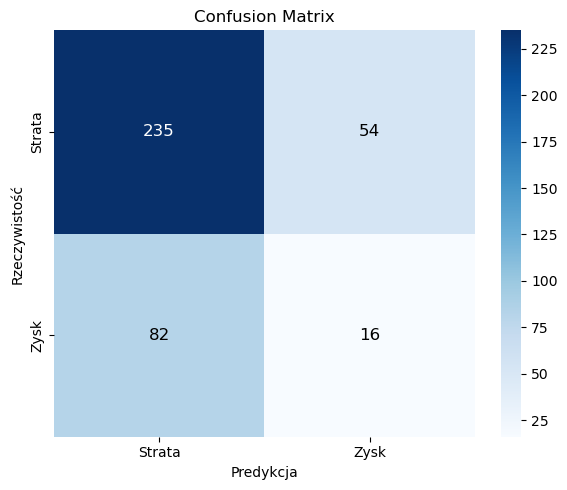

Index(['RSI_lt_30', 'RSI_30_40', 'RSI_40_50', 'RSI_50_65', 'RSI_65_75',
       'William_lt_-80', 'William_-80_-60', 'William_-60_-40',
       'William_-40_-20', 'K_lt_20', 'K_20_50', 'K_50_70', 'K_70_90',
       'D_lt_20', 'D_20_50', 'D_50_70', 'D_70_90', 'SMA20>SMA100',
       'EMA20>EMA50', 'EMA10>SMA20', 'EMA10>SMA100', 'EMA20>SMA150',
       'if_SMA_500', 'if_SMA_200', 'if_SMA_150', 'if_SMA_100', 'if_EMA_20'],
      dtype='object')
27
[0.01235958 0.01531036 0.01601026 0.0376899  0.03703722 0.01570366
 0.02109272 0.03629941 0.06909013 0.01631641 0.0256302  0.03466526
 0.06732211 0.02036177 0.03431218 0.0466175  0.07171762 0.06253499
 0.07924029 0.         0.         0.05414062 0.07706914 0.06224689
 0.05830704 0.01574087 0.01318389]
27


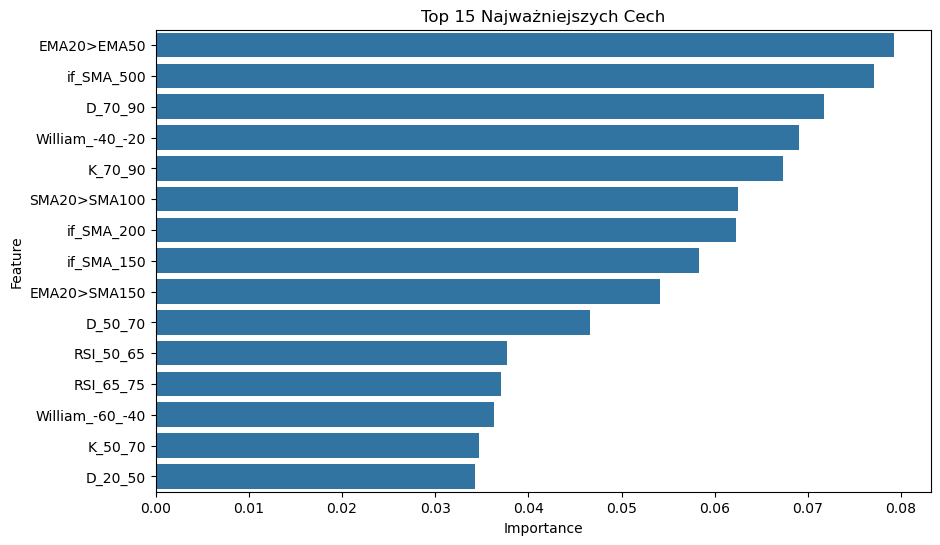

In [46]:
print(start_test_date)
y_pred= model.predict(X_train)
print("Classification Report for train:")
print(classification_report(y_train, y_pred))

y_pred = model.predict(X_test)
print("Classification Report for test:")
print(classification_report(y_test, y_pred))

# === 5. Macierz pomyłek ===

confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Tworzenie wykresu bez automatycznych anotacji
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=['Strata', 'Zysk'], yticklabels=['Strata', 'Zysk'])

# Ręczne wypisanie wartości z kontrolą koloru
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = "white" if cm[i, j] > cm.max() / 2 else "black"
        ax.text(j + 0.5, i + 0.5, str(value), ha="center", va="center", color=color, fontsize=12)

plt.xlabel('Predykcja')
plt.ylabel('Rzeczywistość')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# === 6. Ważność cech ===

importances = model.feature_importances_
feature_names = X.columns
print(feature_names)
print(len(feature_names))
print(importances)
print(len(importances))
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Najważniejszych Cech")
plt.show()

In [47]:
#X_test_reset = X_test.reset_index(drop=True)
#y_test_reset = y_test.reset_index(drop=True)
y_pred_series = pd.Series(y_pred, name='y_pred')

# Łączenie danych
results_df = pd.concat([X_test, y_test.rename('y_true'), y_pred_series], axis=1)

# Zapis do Excela

print(results_df)
results_df.to_excel("porownanie_predykcji.xlsx", index=False)

print("Plik 'porownanie_predykcji.xlsx' został zapisany.")

     RSI_lt_30  RSI_30_40  RSI_40_50  RSI_50_65  RSI_65_75  William_lt_-80  \
0            0          0          1          0          0               0   
1            0          0          0          1          0               0   
2            0          0          0          1          0               0   
3            0          0          0          1          0               0   
4            0          0          0          1          0               0   
..         ...        ...        ...        ...        ...             ...   
382          0          0          0          1          0               0   
383          0          0          0          1          0               0   
384          0          1          0          0          0               1   
385          0          0          0          1          0               0   
386          0          0          0          1          0               0   

     William_-80_-60  William_-60_-40  William_-40_-20  K_lt_20

In [48]:
print(results_df)

     RSI_lt_30  RSI_30_40  RSI_40_50  RSI_50_65  RSI_65_75  William_lt_-80  \
0            0          0          1          0          0               0   
1            0          0          0          1          0               0   
2            0          0          0          1          0               0   
3            0          0          0          1          0               0   
4            0          0          0          1          0               0   
..         ...        ...        ...        ...        ...             ...   
382          0          0          0          1          0               0   
383          0          0          0          1          0               0   
384          0          1          0          0          0               1   
385          0          0          0          1          0               0   
386          0          0          0          1          0               0   

     William_-80_-60  William_-60_-40  William_-40_-20  K_lt_20

In [49]:
X_test2 = X_test.copy()
X_test2['P&L without_estimated_fees'] = df.loc[X_test.index, 'P&L without_estimated_fees']
y_pred_series = pd.Series(y_pred, name='y_pred', index=X_test2.index)
results_df = pd.concat([X_test2, y_test.rename('y_true'), y_pred_series], axis=1)

# Zapis do Excela
results_df.to_excel("porownanie_predykcji.xlsx", index=False)
print("Plik 'porownanie_predykcji.xlsx' został zapisany.")
print(results_df)

Plik 'porownanie_predykcji.xlsx' został zapisany.
     RSI_lt_30  RSI_30_40  RSI_40_50  RSI_50_65  RSI_65_75  William_lt_-80  \
0            0          0          1          0          0               0   
1            0          0          0          1          0               0   
2            0          0          0          1          0               0   
3            0          0          0          1          0               0   
4            0          0          0          1          0               0   
..         ...        ...        ...        ...        ...             ...   
382          0          0          0          1          0               0   
383          0          0          0          1          0               0   
384          0          1          0          0          0               1   
385          0          0          0          1          0               0   
386          0          0          0          1          0               0   

     William_

In [50]:
pnl_suma = results_df.groupby('y_pred')['P&L without_estimated_fees'].sum()

# Wyświetlenie wyników
print("Suma P&L dla y_pred == 0:", pnl_suma.get(0, 0))
print("Suma P&L dla y_pred == 1:", pnl_suma.get(1, 0))

Suma P&L dla y_pred == 0: 184666.99554081686
Suma P&L dla y_pred == 1: -19996.532481937415


In [51]:
grouped = results_df.groupby('y_pred')['P&L without_estimated_fees'].agg(['sum', 'count'])

# Obliczanie średniej
grouped['mean'] = grouped['sum'] / grouped['count']

# Wyświetlenie wyników
print("Średnia P&L dla y_pred == 0:", grouped.loc[0, 'mean'] if 0 in grouped.index else 0)
print("Średnia P&L dla y_pred == 1:", grouped.loc[1, 'mean'] if 1 in grouped.index else 0)

Średnia P&L dla y_pred == 0: 582.5457272580974
Średnia P&L dla y_pred == 1: -285.6647497419631


In [52]:
from sklearn.metrics import precision_score

y_proba = model.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_proba >= 0.65).astype(int)  # zwiększ próg np. do 0.7

precision = precision_score(y_test, y_pred_adjusted)
print("Adjusted precision for class 1:", precision)

Adjusted precision for class 1: 0.22857142857142856


Classification Report for test:
              precision    recall  f1-score   support

           0       0.74      0.91      0.82       289
           1       0.23      0.08      0.12        98

    accuracy                           0.70       387
   macro avg       0.49      0.49      0.47       387
weighted avg       0.61      0.70      0.64       387



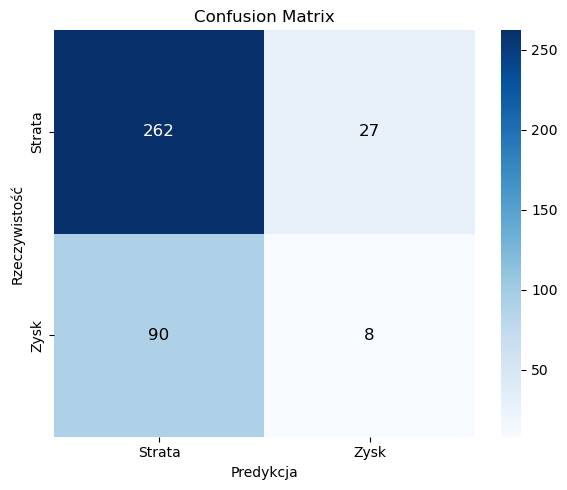

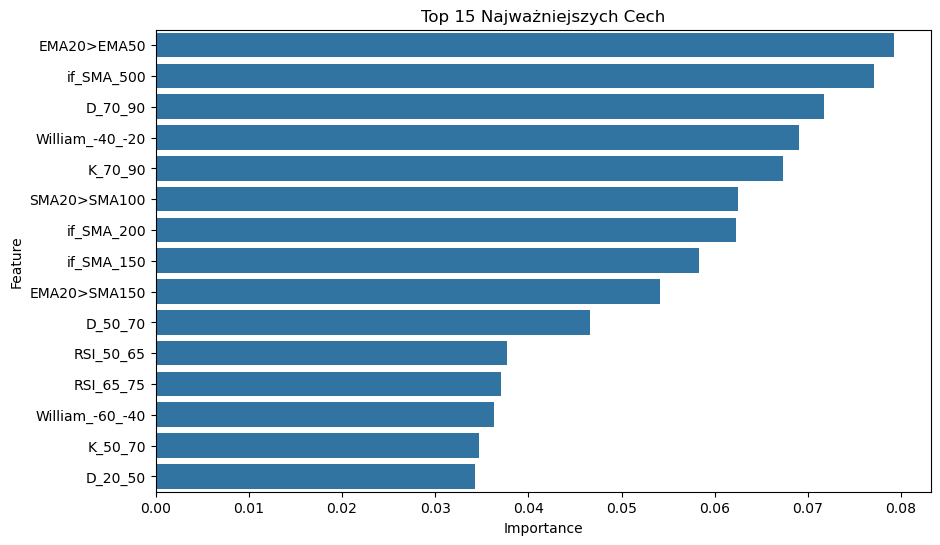

In [53]:


y_pred = y_pred_adjusted
print("Classification Report for test:")
print(classification_report(y_test, y_pred))

# === 5. Macierz pomyłek ===

confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Tworzenie wykresu bez automatycznych anotacji
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=['Strata', 'Zysk'], yticklabels=['Strata', 'Zysk'])

# Ręczne wypisanie wartości z kontrolą koloru
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = "white" if cm[i, j] > cm.max() / 2 else "black"
        ax.text(j + 0.5, i + 0.5, str(value), ha="center", va="center", color=color, fontsize=12)

plt.xlabel('Predykcja')
plt.ylabel('Rzeczywistość')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# === 6. Ważność cech ===

importances = model.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Najważniejszych Cech")
plt.show()

In [54]:
#X_test_reset = X_test.reset_index(drop=True)
#y_test_reset = y_test.reset_index(drop=True)
y_pred_series = pd.Series(y_pred, name='y_pred')

# Łączenie danych
results_df = pd.concat([X_test, y_test.rename('y_true'), y_pred_series], axis=1)

# Zapis do Excela

print(results_df)
results_df.to_excel("porownanie_predykcji.xlsx", index=False)

print("Plik 'porownanie_predykcji.xlsx' został zapisany.")

     RSI_lt_30  RSI_30_40  RSI_40_50  RSI_50_65  RSI_65_75  William_lt_-80  \
0            0          0          1          0          0               0   
1            0          0          0          1          0               0   
2            0          0          0          1          0               0   
3            0          0          0          1          0               0   
4            0          0          0          1          0               0   
..         ...        ...        ...        ...        ...             ...   
382          0          0          0          1          0               0   
383          0          0          0          1          0               0   
384          0          1          0          0          0               1   
385          0          0          0          1          0               0   
386          0          0          0          1          0               0   

     William_-80_-60  William_-60_-40  William_-40_-20  K_lt_20

In [55]:
X_test2 = X_test.copy()
X_test2['P&L without_estimated_fees'] = df.loc[X_test.index, 'P&L without_estimated_fees']
y_pred_series = pd.Series(y_pred, name='y_pred', index=X_test2.index)
results_df = pd.concat([X_test2, y_test.rename('y_true'), y_pred_series], axis=1)

# Zapis do Excela
results_df.to_excel("porownanie_predykcji.xlsx", index=False)
print("Plik 'porownanie_predykcji.xlsx' został zapisany.")
print(results_df)

Plik 'porownanie_predykcji.xlsx' został zapisany.
     RSI_lt_30  RSI_30_40  RSI_40_50  RSI_50_65  RSI_65_75  William_lt_-80  \
0            0          0          1          0          0               0   
1            0          0          0          1          0               0   
2            0          0          0          1          0               0   
3            0          0          0          1          0               0   
4            0          0          0          1          0               0   
..         ...        ...        ...        ...        ...             ...   
382          0          0          0          1          0               0   
383          0          0          0          1          0               0   
384          0          1          0          0          0               1   
385          0          0          0          1          0               0   
386          0          0          0          1          0               0   

     William_

In [56]:
X_test2 = X_test.copy()
X_test2['P&L without_estimated_fees'] = df.loc[df.index, 'P&L without_estimated_fees']
y_pred_series = pd.Series(y_pred, name='y_pred', index=X_test2.index)
results_df = pd.concat([X_test2, y_test.rename('y_true'), y_pred_series], axis=1)

# Zapis do Excela
results_df.to_excel("porownanie_predykcji.xlsx", index=False)
print("Plik 'porownanie_predykcji.xlsx' został zapisany.")
print(results_df)

Plik 'porownanie_predykcji.xlsx' został zapisany.
     RSI_lt_30  RSI_30_40  RSI_40_50  RSI_50_65  RSI_65_75  William_lt_-80  \
0            0          0          1          0          0               0   
1            0          0          0          1          0               0   
2            0          0          0          1          0               0   
3            0          0          0          1          0               0   
4            0          0          0          1          0               0   
..         ...        ...        ...        ...        ...             ...   
382          0          0          0          1          0               0   
383          0          0          0          1          0               0   
384          0          1          0          0          0               1   
385          0          0          0          1          0               0   
386          0          0          0          1          0               0   

     William_

In [57]:
pnl_suma = results_df.groupby('y_pred')['P&L without_estimated_fees'].sum()

# Wyświetlenie wyników
print("Suma P&L dla y_pred == 0:", pnl_suma.get(0, 0))
print("Suma P&L dla y_pred == 1:", pnl_suma.get(1, 0))

Suma P&L dla y_pred == 0: 177742.52030289828
Suma P&L dla y_pred == 1: -13072.05724401883


In [58]:
grouped = results_df.groupby('y_pred')['P&L without_estimated_fees'].agg(['sum', 'count'])

# Obliczanie średniej
grouped['mean'] = grouped['sum'] / grouped['count']

# Wyświetlenie wyników
print("Średnia P&L dla y_pred == 0:", grouped.loc[0, 'mean'] if 0 in grouped.index else 0)
print("Średnia P&L dla y_pred == 1:", grouped.loc[1, 'mean'] if 1 in grouped.index else 0)

Średnia P&L dla y_pred == 0: 504.9503417695974
Średnia P&L dla y_pred == 1: -373.4873498291094
